In [1]:
"""
This example shows how to perform regression of molecular properties with a
database of the atomic geometry of water clusters with an associated energy, 
using a simple GNN in disjoint mode.
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mendeleev import H, O

# Install matplotlib inside the virtual env
#import pip
#pip.main(["install","matplotlib"])
import matplotlib.pyplot as plt

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.datasets import QM9
from spektral.layers import GCSConv, ECCConv, GlobalSumPool, MessagePassing, GATConv, CrystalConv

#from spektral.utils import normalized_adjacency

import os

2024-02-20 11:44:14.124517: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 11:44:14.126554: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 11:44:14.151362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 11:44:14.151392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 11:44:14.152176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
N = 32 

# Read initial geometry to initialize the GNN model

data_dir = "../dataset_WaterClusters_big/"
file_name = data_dir+"N"+str(N)+"-T100/1000.dat"

class MyDataset(Dataset):

    # Define an auxiliar dataset with one single graph

    def __init__(self, r2_cutoff, **kwargs):

        self.r2_cutoff = r2_cutoff
        self.geometry_path = file_name
        super().__init__(**kwargs)

    # Define data matrices of a graph (x,a,e)

    def read(self):
            
        def make_graph():

            # Process the header of the geometry file
            geom_path = self.geometry_path
            gfile = open(geom_path,'r')
            line = gfile.readline()
            n_molecules = int(gfile.readline())
            line = gfile.readline()
            line = gfile.readline()
            line = gfile.readline()
            columns = line.split()
            energy = float(columns[0])
            #energy = float(columns[1]) # electron contribution
            line = gfile.readline()
            line = gfile.readline()            

            # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            num_physical_features = 4
            num_abstract_features = 0
            num_node_features = num_physical_features + num_abstract_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0):
                    x[inode,0] = O.atomic_number
                else:
                    x[inode,0] = H.atomic_number
                pos[inode,0:] = columns[1:]
                x[inode,1:] = pos[inode,0:]
            gfile.close()                

            # Binary Adjacency matrix (two nodes/atoms are connected if rij2 < r2_cutoff)
            a = np.zeros((n_nodes,n_nodes))
            n_edges = 0
            for iatom in range(3*n_molecules):
                for jatom in range(iatom+1,3*n_molecules):
                    rij = pos[iatom,0:] - pos[jatom,0:]
                    r2 = np.dot(rij,rij)
                    if (r2 <= self.r2_cutoff):
                        a[iatom,jatom] = 1
                        n_edges = n_edges + 1            
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            #a = normalized_adjacency(a, symmetric=True)
            
            # No edge features in this case
                
            # Labels
            num_labels = 1
            self.num_labels = num_labels
            y = np.zeros(num_labels,)
            y[0,] = energy

            print(str(geom_path)+"    Energy "+str(y[0,]))

            return Graph(x=x, a=a, y=y)

        # We must return a list of Graph objects
        return [make_graph()]        

d_cutoff = 6.0
d2_cutoff = d_cutoff * d_cutoff
dataset0 = MyDataset( d2_cutoff ) # dataset with initial graph
dataset_aux = MyDataset( d2_cutoff ) # auxiliar dataset

../dataset_WaterClusters_big/N32-T100/1000.dat    Energy -0.41267015
../dataset_WaterClusters_big/N32-T100/1000.dat    Energy -0.41267015


In [3]:
# Initialize the GNN model

# Config 
learning_rate = 1e-3  # Learning rate
epochs = 1  # Number of training epochs
batch_size = 1  # Batch size
n_out = 1
loader_tr = DisjointLoader(dataset0, batch_size=batch_size, epochs=epochs)

# Build the model
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0,activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense1 = Dense(128,activation="relu")
        self.dense2 = Dense(128,activation="relu")
        self.dense = Dense(n_out)

    def call(self, inputs):
        #x, a, e, i = inputs
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        output = self.global_pool([x, i])
        output = self.dense1(output)
        output = self.dense2(output)
        output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
loss_fn = MeanAbsoluteError()

@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# fit the model one epoch
nepoch = 1
step = loss = 0
loss_train = []
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss_train.append(loss / loader_tr.steps_per_epoch)

        nepoch = nepoch + 1
        
        loss = 0

# Load pre-trained weights

# load model weights
model.load_weights('../Models/GATConv_electron_weights.hdf5')
#model.load_weights('../Models/GATConv_weights.hdf5')

# Show the model architecture
model.summary()

2024-02-20 11:44:37.586442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 11:44:37.604381: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alfonso/Work/UGR/Calculations/WaterClusterAnions_GNNs/.venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., no

1 Loss: 10.643238067626953
Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gat_conv (GATConv)          multiple                  392       
                                                                 
 gat_conv_1 (GATConv)        multiple                  3304      
                                                                 
 global_sum_pool (GlobalSum  multiple                  0         
 Pool)                                                           
                                                                 
 dense (Dense)               multiple                  7296      
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  129       
                                    

In [4]:
# Function to evaluate the energy of a new molecular geometry

def energy_GNN(inputs):

    # Inputs are data matrices of the graph
    x, a, e = inputs

    # We save the new graph into the auxiliar dataset and define
    # a disjoint loader to evaluate model
    graph_aux = Graph(x=x,a=a,e=e,y=0)
    dataset_aux[0] = graph_aux
    loader_aux = DisjointLoader(dataset_aux, epochs=1) 
    for batch in loader_aux:
        input, y = batch
        energy_predicted = model(input, training=False)

    return float(energy_predicted)

# Check the implementation
graph0 = dataset0[0]
x0 = graph0.x
a0 = graph0.a
e0 = graph0.e
y0 = graph0.y
inputs = [x0, a0, e0]
print( "Predicted: "+str(energy_GNN(inputs)) )

Predicted: -0.05810457095503807


In [5]:
print(x0.shape)
print(a0.shape)
print(e0)
print(y0)

(96, 4)
(96, 96)
None
[-0.41267015]


In [6]:
# Function to compute adjacency matrix from the atomic positions

def adjacency(position):

    nat,ndim = position.shape
    nat = int(nat)
    nmol = int(nat/3)
    
    a = np.zeros((nat,nat))

    for iatom in range(nat):
        for jatom in range(iatom+1,nat):
            rij = position[iatom,:] - position[jatom,:]
            r2 = np.dot(rij,rij)
            if (r2 <= d2_cutoff):
                a[iatom,jatom] = 1
    a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
    a = sp.csr_matrix(a)
    
    return a

In [7]:
# Read single geometry and predict its electronic energy

data_dir = "../dataset_WaterClusters_big/"
#file_name = data_dir+"N"+str(N)+"-T100/2000.dat"
file_name = data_dir+"N237"+"-T100/2000.dat"

gfile = open(file_name,'r')
line = gfile.readline()
line = gfile.readline()
columns = line.split()
nmols = int(columns[0])
natoms = 3*nmols
pos = np.zeros((natoms,3))
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()
line = gfile.readline()

for i in range(natoms):
    line = gfile.readline()
    #print(line)
    columns = line.split()
    pos[i,0] = float(columns[1])
    pos[i,1] = float(columns[2])
    pos[i,2] = float(columns[3])
gfile.close()

# Convert from ang to a.u. 
#ang_to_au = 1e0 / 0.529177e0
#pos = pos * ang_to_au
#print(pos0[0,:])

# Define node atributes and adjacency matrix

x = np.zeros((natoms,4))
a = np.zeros((natoms,natoms))
e = e0
y = y0
""" for i in range(natoms):
    if (i%3==0):
        x[i,0] = 8.0 # oxygen
    else:
        x[i,0] = 1.0 # hydrogen
    x[i,1:] = pos[i,:] """
x[:,0] = 1.0 # hydrogens
for i in range(nmols):
    x[int(3*i),0] = 8.0 # oxygens
x[:,1:] = pos[:,:]

a = adjacency(pos)
inputs = [x, a, e]
print( "Predicted: "+str(energy_GNN(inputs)) )

Predicted: -0.11131839454174042


In [8]:
################################################################################
# Measure evaluation time for an specific cluster size
################################################################################
import time 

#cluster_size = 20 

time_evaluation = []
time_adjacency = []
for N in [20,32,47,76,100,139,190,237]:
    print('Size: '+str(N))

    data_dir = "../dataset_WaterClusters_big/"+"N"+str(N)+"-T100/"
    files_names = os.listdir(data_dir)
    print('n_clusters: '+str(len(files_names)))

    time_evaluation_total = 0
    time_adjacency_total = 0
    for file_name in files_names:

        #print(file_name)
        gfile = open(data_dir+file_name,'r')
        line = gfile.readline()
        line = gfile.readline()
        columns = line.split()
        nmols = int(columns[0])
        natoms = 3*nmols
        pos_ini = np.zeros((natoms,3))
        line = gfile.readline()
        line = gfile.readline()
        line = gfile.readline()
        line = gfile.readline()
        line = gfile.readline()

        for i in range(natoms):
            line = gfile.readline()
            #print(line)
            columns = line.split()
            pos_ini[i,0] = float(columns[1])
            pos_ini[i,1] = float(columns[2])
            pos_ini[i,2] = float(columns[3])
        gfile.close()
    
        # Define node atributes and adjacency matrix
        t_init = time.time()
        x_ini = np.zeros((natoms,4))
        a_ini = np.zeros((natoms,natoms))
        e_ini = e0
        y_ini = y0
        x_ini[:,0] = 1.0 # hydrogens
        for i in range(nmols):
            x_ini[int(3*i),0] = 8.0 # oxygens
        x_ini[:,1:] = pos_ini[:,:]
        a_ini = adjacency(pos_ini)
        t_end = time.time()
        time_adj = t_end - t_init
        time_adjacency_total = time_adjacency_total + time_adj

        # Evaluation time
        t_init = time.time()
        inputs = [x_ini, a_ini, e_ini]
        Energy = energy_GNN(inputs)
        t_end = time.time()
        time_ev = t_end - t_init
        time_evaluation_total = time_evaluation_total + time_ev

    time_adjacency.append(time_adjacency_total/len(files_names))    
    time_evaluation.append(time_evaluation_total/len(files_names))

    """ data_dir = "../dataset_WaterClusters_big/"
    file_name = data_dir+"N"+str(N)+"-T100/1000.dat"

    gfile = open(file_name,'r')
    line = gfile.readline()
    line = gfile.readline()
    columns = line.split()
    nmols = int(columns[0])
    natoms = 3*nmols
    pos_ini = np.zeros((natoms,3))
    line = gfile.readline()
    line = gfile.readline()
    line = gfile.readline()
    line = gfile.readline()
    line = gfile.readline()

    for i in range(natoms):
        line = gfile.readline()
        #print(line)
        columns = line.split()
        pos_ini[i,0] = float(columns[1])
        pos_ini[i,1] = float(columns[2])
        pos_ini[i,2] = float(columns[3])
    gfile.close()
    
    # Define node atributes and adjacency matrix
    t_init = time.time()
    x_ini = np.zeros((natoms,4))
    a_ini = np.zeros((natoms,natoms))
    e_ini = e0
    y_ini = y0
    x_ini[:,0] = 1.0 # hydrogens
    for i in range(nmols):
        x_ini[int(3*i),0] = 8.0 # oxygens
    x_ini[:,1:] = pos_ini[:,:]
    a_ini = adjacency(pos_ini)
    t_end = time.time()
    time_adj = t_end - t_init
    time_adjacency.append(time_adj)

    # Evaluation time
    t_init = time.time()
    inputs = [x_ini, a_ini, e_ini]
    Energy = energy_GNN(inputs)
    t_end = time.time()
    time_ev = t_end - t_init
    time_evaluation.append(time_ev)
    print( "Predicted: "+str(Energy) )

    time_total = time_adj + time_ev    
    print("cluster_size: "+str(N)+", time_evaluation: "+str(time_ev))
    print("cluster_size: "+str(N)+", time_adjacency: "+str(time_adj)) """

print(time_adjacency)
print(time_evaluation)

Size: 20
n_clusters: 40
Size: 32
n_clusters: 40
Size: 47
n_clusters: 40
Size: 76
n_clusters: 40
Size: 100
n_clusters: 40
Size: 139
n_clusters: 40
Size: 190
n_clusters: 40
Size: 237
n_clusters: 40
[0.0026146054267883303, 0.006195145845413208, 0.01281026005744934, 0.03394362926483154, 0.05936091542243958, 0.11379966735839844, 0.21040377616882325, 0.33184614777565]
[0.011191213130950927, 0.011365896463394165, 0.011656230688095093, 0.013741576671600341, 0.014857643842697143, 0.015557843446731567, 0.017346709966659546, 0.01807679533958435]


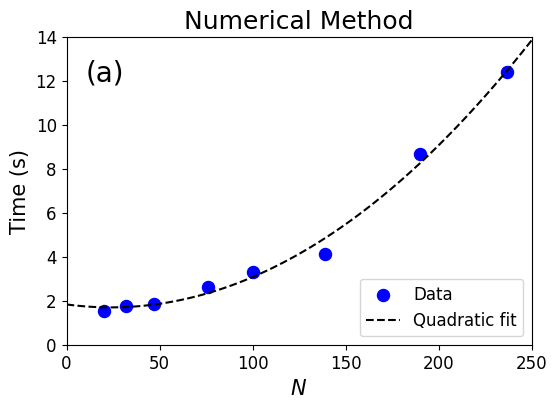

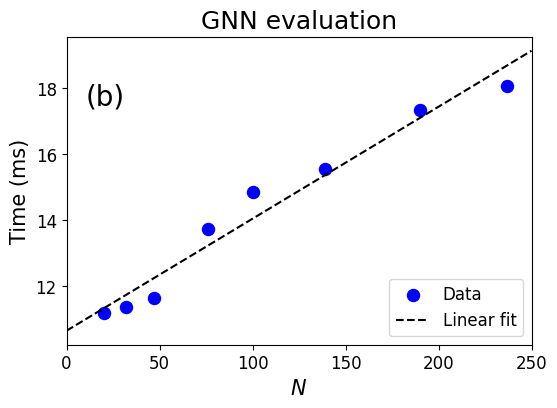

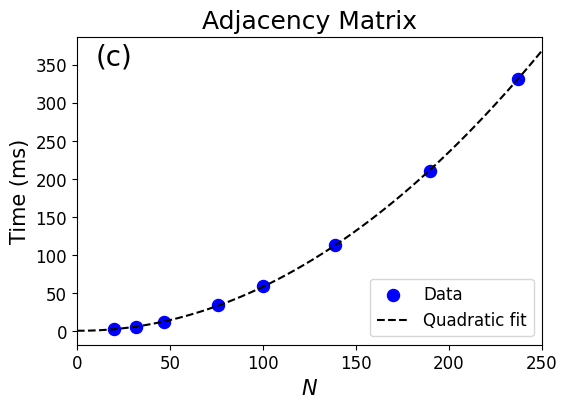

In [20]:
#############################
# Plot Time vs N
#############################

time_Schrodinger = [1.52, 1.78, 1.83, 2.64, 3.29, 4.11, 8.67, 12.39]
#time_electron = [0.0003378003835678101, 0.0005262777209281922, 0.0007659897208213806, 0.0012963429093360902, 0.0017568498849868774, 0.002617451548576355, 0.003850002586841583, 0.005050760507583618]
N = [20, 32, 47, 76, 100, 139, 190, 237]

time_Schrodinger = np.array(time_Schrodinger)
time_evaluation = np.array(time_evaluation)
time_adjacency = np.array(time_adjacency)
N = np.array(N)

# quadratical fit for the numerical method
x_data = np.linspace(0,250,100)
model_quad = np.poly1d(np.polyfit(N,time_Schrodinger,2))
y_fit = model_quad(x_data)

plt.figure(figsize=(6,4))
plt.scatter(N, time_Schrodinger, color='blue',label = "Data",s=75.0)
plt.plot(x_data, model_quad(x_data), 'k--', label="Quadratic fit",)
#plt.xlabel("Cluster Size (# of water molecules)",fontsize=15)
plt.xlabel("$N$",fontsize=15)
plt.ylabel("Time (s)",fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.title("Numerical Method",fontsize=18)
plt.text(10,12,"(a)",fontsize=20,color='black')
plt.xlim([0,250])
plt.ylim([0,14])
plt.show()

# linear fit for the GNN evaluation
x_data = np.linspace(0,250,100)
model_linear = np.poly1d(np.polyfit(N,time_evaluation,1))
y_fit = model_linear(x_data)

plt.figure(figsize=(6,4))
plt.scatter(N, time_evaluation*1000, color='blue',label='Data',s=75.0)
plt.plot(x_data, model_linear(x_data)*1000, 'k--',label="Linear fit")
#plt.scatter(N, time_evaluation, color='blue',label='Data',s=75.0)
#plt.plot(x_data, model_linear(x_data), 'k--',label="Linear fit")
#plt.xlabel("Cluster Size (# of water molecules)",fontsize=15)
plt.xlabel("$N$",fontsize=15)
plt.ylabel("Time (ms)",fontsize=15)
#plt.ylabel("Time (s)",fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.title("GNN evaluation",fontsize=18)
plt.xlim([0,250])
#plt.ylim([0,20])
plt.text(10,17.5,"(b)",fontsize=20,color='black')
plt.show()

# quadratical fit for the Adjacency matrix
x_data = np.linspace(0,250,100)
model_quad = np.poly1d(np.polyfit(N,time_adjacency,2))
y_fit = model_quad(x_data)

plt.figure(figsize=(6,4))
plt.scatter(N, time_adjacency*1000, color='blue',label='Data',s=75.0)
plt.plot(x_data, model_quad(x_data)*1000, 'k--',label="Quadratic fit")
#plt.xlabel("Cluster Size (# of water molecules)",fontsize=15)
plt.xlabel("$N$",fontsize=15)
plt.ylabel("Time (ms)",fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right",fontsize=12)
plt.title("Adjacency Matrix",fontsize=18)
plt.xlim([0,250])
#plt.ylim([0,20])
plt.text(10,350,"(c)",fontsize=20,color='black')
plt.show()

In [10]:
print(time_Schrodinger/time_adjacency)

[581.34966922 287.32172646 142.85424275  77.77600855  55.42367358
  36.11609854  41.20648478  37.33657926]
